# Modules

In [37]:
import pandas as pd # routine analysis with dataframes
import numpy as np # routine array analysis
import pickle # reading in pickle files (PCA morphospace file)
from scipy.spatial import ConvexHull # for calculating convex hull of morphospace
from scipy.spatial import Delaunay # for delauney triangulation functions
from scipy.stats import dirichlet # for sampling simplices in the morphospace
from numpy.linalg import det # for sampling simplices in the morphospace
import math # for math functions
import os # for directory functions
import matplotlib.pyplot as plt # for plotting
from shapely.geometry import Polygon, Point

# Functions

In [38]:
def save_params(keys, values, path):

    """
    Given lists of parameter variable names and values, saves as csv file to desired path
    
    Inputs 
    keys: a list of keys, parameter names
    values: a list of values, parameter values
    path: a filename path to save the param values as .csv file

    Outputs:
    No return, saves the csv to the desired path
    """
    
    # convert values into lists
    list_vals = [[x] for x in values]
    
    # convert parameter names and values into dictionary
    data = dict(zip(keys, list_vals))
    
    # convert dict into df
    df = pd.DataFrame.from_dict(data)
    
    # save param values
    df.to_csv(path, index=False)

def set_params(path):

    """
    Given a path, read in a csv file with parameter variable names and values
    
    Inputs 
    path: a filename path to read in a csv 

    Outputs:
    Sets global variables and values from the csv file
    Returns a dictionary of parameter names and values
    """
    
    # read in param values from csv
    df = pd.read_csv(path)
    
    # create variables for parameters
    for column in df.columns:
        globals()[column] = df[column].item()

    # create a dictionary of parameter variables to return
    param_var_list = [
        "parameter_name", 
        "morphospace_file", 
        "PC_val_file",
        "PCa", 
        "PCb",
        "grid_density",
        "low_lf_num",
        "high_lf_num",
        "low_juv_len",
        "high_juv_len",
        "low_adult_len",
        "high_adult_len",
        "lf_curve",
        "lf_curl",
        "max_down_curl",
        "max_up_curl",
        "ang_min_limit",
        "ang_max_limit",
        "phyllo_option"]

    param_val_list = [
        parameter_name, 
        morphospace_file, 
        PC_val_file,
        PCa, 
        PCb,
        grid_density,
        low_lf_num,
        high_lf_num,
        low_juv_len,
        high_juv_len,
        low_adult_len,
        high_adult_len,
        lf_curve,
        lf_curl,
        max_down_curl,
        max_up_curl,
        ang_min_limit,
        ang_max_limit,
        phyllo_option]
    
    # convert parameter names and values into dictionary
    param_var_dict = dict(zip(param_var_list, param_val_list))

    return param_var_dict

def dist_in_hull(points, n):

    """
    From: https://stackoverflow.com/questions/59073952/how-to-get-uniformly-distributed-points-in-convex-hull
    Accessed 11 February 2024
    
    Given a set of points, find delauney simplices of hull and randomly sample n points within

    Inputs:
    points: an array of point values, any dimensions
    n: the number of points to sample within the convex hull

    Outputs
    coordinates of randomly sampled points (array)
    """
    
    dims = points.shape[-1]
    hull = points[ConvexHull(points).vertices]
    deln = hull[Delaunay(hull).simplices]

    vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / math.factorial(dims)    
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum())

    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

def select_leaf_number(low_lf_num, high_lf_num):
    """
    Given low and high leaf number values, uniformly sample a leaf number for the plant
    
    Inputs
    low_lf_num: integer value of lowest possible leaf number (inclusive)
    high_lf_num: integer value of highest possible leaf number (not included)

    Ouputs
    n: the selected leaf number uniformly sampled from provided range
    """

    return np.random.randint(low_lf_num, high_lf_num) 

def select_phyllotaxy_angle(phyllo_option):
    """
    Given a phyllotaxy angle option value (see below) set phyllotaxy angle

    Inputs
    phyllo_option: integer value selecting phyllotaxy option

    Outputs
    phyllo_ang: float value of calculated phyllotaxy angle
    """

    # 0 = [-137.5077640500378546463487,137.5077640500378546463487]
    # 1 = [-137.5077640500378546463487,137.5077640500378546463487,90,180]
    # 2 = [-137.5077640500378546463487,137.5077640500378546463487,90,180,<random -360 to +360>]
    # 3 = [<random -360 to +360>]

    if phyllo_option==0:
        phyllo_ang=np.random.choice(np.array([-137.5077640500378546463487,137.5077640500378546463487]))
    elif phyllo_option==1:
        phyllo_ang=np.random.choice(np.array([-137.5077640500378546463487,137.5077640500378546463487,90,180]))
    elif phyllo_option==2:
        phyllo_ang=np.random.choice(np.array([-137.5077640500378546463487,137.5077640500378546463487,90,180,np.random.uniform(-360,360)]))
    else:
        phyllo_ang=np.random.uniform(-360,360)

    return phyllo_ang

def select_leaf_lengths(low_juv_len, high_juv_len, low_adult_len, high_adult_len):
    """
    Given relative leaf lengths of start (juvenile) and end (adult) of leaf series, set relative leaf lengths

    Inputs
    low_juv_len: low limit juvenile leaf length (relative to 1)
    high_juv_len: high limit juvenile leaf length (relative to 1)
    low_adult_len: low limit adult leaf length (relative to 1)
    high_adult_len: high limit adult leaf length (relative to 1)

    Outputs
    juv_len: the relative length to 1 of juvenile leaf
    adult_len: the relative length to 1 of the adult leaf
    node_max: the node in the leaf series of the max leaf height (from 0 to 1)
    """
    # select relative height of first leaf in series
    juv_len = np.random.uniform(low_juv_len, high_juv_len) 
    
    # set node position of max leaf height of 1 (0 to 1)
    node_max = np.random.uniform(0.1, 0.9) # a little bit in from 0 and 1 at 0.1 to 0.9
    
    # set the relative height of last leaf in series
    adult_len = np.random.uniform(low_adult_len, high_adult_len) 

    return juv_len, adult_len, node_max

def select_leaf_surface_variables(lf_curve, lf_curl, max_down_curl, max_up_curl):
    """
    Given curvature and curling scaling values and positioning of curling, return leaf surface (z axis) values

    Inputs:
    lf_curve: scaling factor for the amount of leaf curvature (relative to leaf margins)
    lf_curl: scaling factor for the amount of leaf curling (from base to tip)
    max_down_curl: a 0 to 1 value of maximum downward curl
    max_up_curl: a 0 to 1 value of maximum upward curl

    Outputs:
    leaf_curve: the leaf curvature scaling amount
    leaf_curl: the leaf curling scaling amount
    leaf_tip: the leaf curling value at the tip of the leaf
    leaf_mid: the leaf curling value at the mid point of the leaf length
    """
    # calculate the scaling factor for leaf curvature and leaf curl
    leaf_curve = np.random.uniform(0,lf_curve) 
    leaf_curl = np.random.uniform(0,lf_curl) 
    
    # calculate leaf curl amount (z value)
    leaf_tip = np.random.uniform(max_down_curl,max_up_curl) 
    
    # set middle of leaf curl (also z value, but curl at mid point of length)
    leaf_mid = np.random.uniform(0,leaf_tip) 

    return leaf_curve, leaf_curl, leaf_tip, leaf_mid

def select_leaf_elevation_angles(ang_min_limit, ang_max_limit):
    """
    Given the minimum and maximum leaf angle limits, calculate the leaf elevation limits

    Inputs
    ang_min_limit: the minimum angle limit (in the context of 0 to the limit)
    ang_max_limit: the maximum angle limit (in the context of the selected min angle to the max limit)

    Outputs
    angle_min: the selected minimum angle value
    angle_max: the selected maximum angle value
    """
    # calculate elevation angles
    angle_min = np.random.uniform(0,ang_min_limit) # get the minimum angle
    angle_max = np.random.uniform(angle_min,ang_max_limit) # get the maximum angle\

    return angle_min, angle_max

def select_morphospace_points(morphospace_file, PC_val_file, PCa, PCb):
    """
    Given a morphospace and PC values select morphospace points to generate a leaf shape series

    Inputs
    morphospace_file: path to a morphospace file (.pkl)
    PC_val_file: path to PC value file (.npy)
    PCa: the first PC axis to consider (index starts at 0)
    PCb: the second PC axis to consider (index starts at 0)

    Outputs:
    start_x: the x value (PCa) of the leaf series start
    start_y: the y value (PCb) of the leaf series start
    end_x: the x value (PCa) of the leaf series end
    end_y: the y value (PCb) of the leaf series end
    """
    # find the two points in PCA space to make the leaf series
    # Load PCA model
    with open(morphospace_file, 'rb') as file:
        pca = pickle.load(file)
    # Load in PC values
    PCs = np.load(PC_val_file)
    
    # retrieve just the desired two PCs
    just_PCs = PCs[:,[PCa,PCb]]
    # create the convex hull
    hull = ConvexHull(just_PCs)
    # retreieve hull points
    hull_points = just_PCs[hull.vertices]
    # find two random points in 2D convex hull
    # these are the terminal points of the line
    term_pts = dist_in_hull(hull_points,2)
    # these are the values of the coordinate points
    start_x = term_pts[0][0]
    start_y = term_pts[0][1]
    end_x = term_pts[1][0]
    end_y = term_pts[1][0]

    return start_x, start_y, end_x, end_y

def save_model_values(param_var_dict, model_results_path, n_models):
    """
    Given parameter values, generate and save values to create models

    Inputs
    param_var_dict: a dictionary of parameter variables and values
    model_results_path: path to create a folder to save model values
    n_models: the desired number of model values to save

    Outputs
    No return, but save desirved number of model values in specified folder as csv files
    """

    if not os.path.exists(model_results_path): # check if the folder exists
        # create the folder if it doesn't exist
        os.makedirs(model_results_path)

    # unpack parameter variable list
    parameter_name=param_var_dict["parameter_name"]
    morphospace_file=param_var_dict["morphospace_file"]
    PC_val_file=param_var_dict["PC_val_file"]
    PCa=param_var_dict["PCa"]
    PCb=param_var_dict["PCb"]
    grid_density=param_var_dict["grid_density"]
    low_lf_num=param_var_dict["low_lf_num"]
    high_lf_num=param_var_dict["high_lf_num"]
    low_juv_len=param_var_dict["low_juv_len"]
    high_juv_len=param_var_dict["high_juv_len"]
    low_adult_len=param_var_dict["low_adult_len"]
    high_adult_len=param_var_dict["high_adult_len"]
    lf_curve=param_var_dict["lf_curve"]
    lf_curl=param_var_dict["lf_curl"]
    max_down_curl=param_var_dict["max_down_curl"]
    max_up_curl=param_var_dict["max_up_curl"]
    ang_min_limit=param_var_dict["ang_min_limit"]
    ang_max_limit=param_var_dict["ang_max_limit"]
    phyllo_option=param_var_dict["phyllo_option"]

    for m in range(n_models):
    
        # select number of leaves
        n = select_leaf_number(low_lf_num, high_lf_num)
    
        # select phyllotactic angle
        phyllo_ang = select_phyllotaxy_angle(phyllo_option)
    
        # select leaf lengths
        juv_len, adult_len, node_max = select_leaf_lengths(low_juv_len, high_juv_len, low_adult_len, high_adult_len)
    
        # select leaf surface variables
        leaf_curve, leaf_curl, leaf_tip, leaf_mid = select_leaf_surface_variables(lf_curve, lf_curl, max_down_curl, max_up_curl)
    
        # select leaf elevation angles
        angle_min, angle_max = select_leaf_elevation_angles(ang_min_limit, ang_max_limit)
    
        # select morphospace points
        start_x, start_y, end_x, end_y = select_morphospace_points(morphospace_file, PC_val_file, PCa, PCb)
    
        model_var_list = [
            "n",
            "phyllo_ang",
            "juv_len",
            "adult_len",
            "node_max",
            "leaf_curve",
            "leaf_curl",
            "leaf_tip",
            "leaf_mid",
            "angle_min",
            "angle_max",
            "start_x",
            "start_y",
            "end_x",
            "end_y"
           ]
    
        model_val_list = [
            n,
            phyllo_ang,
            juv_len,
            adult_len,
            node_max,
            leaf_curve,
            leaf_curl,
            leaf_tip,
            leaf_mid,
            angle_min,
            angle_max,
            start_x,
            start_y,
            end_x,
            end_y
            ]

        # convert values into lists
        model_val_list = [[x] for x in model_val_list]
    
        # convert parameter names and values into dictionary
        model_var_dict = dict(zip(model_var_list, model_val_list))

        # convert dict into df
        df = pd.DataFrame.from_dict(model_var_dict)
        
        # save param values
        df.to_csv("./" + model_results_path + "/m" + str(m) + "_" + parameter_name + ".csv", index=False)

def set_model_values(path):
    """
    Given a model values file, read in and set model values

    Inputs
    path: a path to a model value .csv file

    Outputs
    model_var_dict: a dictionary of model values
    The function sets global values for model variables
    """

    # read in model values from csv
    df = pd.read_csv(path)
    
    # create variables for parameters
    for column in df.columns:
        globals()[column] = df[column].item()
    
    # create a dictionary of model values to return
    model_var_list = [
        "n",
        "phyllo_ang",
        "juv_len",
        "adult_len",
        "node_max",
        "leaf_curve",
        "leaf_curl",
        "leaf_tip",
        "leaf_mid",
        "angle_min",
        "angle_max",
        "start_x",
        "start_y",
        "end_x",
        "end_y"
       ]
    
    model_val_list = [
        n,
        phyllo_ang,
        juv_len,
        adult_len,
        node_max,
        leaf_curve,
        leaf_curl,
        leaf_tip,
        leaf_mid,
        angle_min,
        angle_max,
        start_x,
        start_y,
        end_x,
        end_y
        ]
    
    # convert model names and values into dictionary
    model_var_dict = dict(zip(model_var_list, model_val_list))

    return model_var_dict

# 1. Set parameters

### Save parameter names and values

In [39]:
# name of parameter set
parameter_name = "nahuatlleaftest"

# morphospace and PC values to synthesize leaf shape
morphospace_file = "nahuatl_morphospace_may_10_2025.pkl" # PCA model file, .pkl file
PC_val_file = "nahuatl_PCs_may_10_2025.npy" # empirical PCA values from the PCA, .npy file

# select two PC axes to sythesize leaves from
PCa = 0 # index position of first PC (index 0 = PC1)
PCb = 4 # index position of second PC (index 0 = PC1)

# set density of grid to sample points within leaves
grid_density = 0.01 # density to sample points on leaves

# select the range of leaf numbers to uniformly sample from
low_lf_num = 3 # inclusive
high_lf_num = 10 # up to, not including

# set relative height of first leaf in series
low_juv_len = 0.2 # inclusive
high_juv_len = 1 # not including

# set height of last leaf relative to one
low_adult_len = 0.2 # inclusive
high_adult_len = 1 # not including

# set maximum scaling values for leaf curvature and leaf curling
lf_curve = 0.8 # max scaling of leaf curvature (the interior of the leaf)
lf_curl = 0.8 # max scaling of leaf curl (across length of leaf)

# set maximum displacement at leaf tip (y value), relative to -1, 1
max_down_curl = -1 
max_up_curl = 1

# set minimum and maximum limits of leaf angles
ang_min_limit = 10 # max possible min angle
ang_max_limit = 90 # max possible angle

# set phyllotaxy angle option (in degrees)
# select from options below:
# 0 = [-137.5077640500378546463487,137.5077640500378546463487]
# 1 = [-137.5077640500378546463487,137.5077640500378546463487,90,180]
# 2 = [-137.5077640500378546463487,137.5077640500378546463487,90,180,<random -360 to +360>]
# 3 = [<random -360 to +360>]
phyllo_option = 2

# list of parameter names
param_name_list = [
    "parameter_name", 
    "morphospace_file", 
    "PC_val_file",
    "PCa", 
    "PCb",
    "grid_density",
    "low_lf_num",
    "high_lf_num",
    "low_juv_len",
    "high_juv_len",
    "low_adult_len",
    "high_adult_len",
    "lf_curve",
    "lf_curl",
    "max_down_curl",
    "max_up_curl",
    "ang_min_limit",
    "ang_max_limit",
    "phyllo_option"
]

# list of parameter values
param_val_list = [
    parameter_name, 
    morphospace_file, 
    PC_val_file,
    PCa, 
    PCb,
    grid_density,
    low_lf_num,
    high_lf_num,
    low_juv_len,
    high_juv_len,
    low_adult_len,
    high_adult_len,
    lf_curve,
    lf_curl,
    max_down_curl,
    max_up_curl,
    ang_min_limit,
    ang_max_limit,
    phyllo_option
]


### Save parameters to file

In [40]:
# save the parameters to file
save_params(keys=param_name_list, values=param_val_list, path = "./" + parameter_name + "_params.csv")
    

# 2. Calculate model values

### Read in parameter values

In [41]:
# name of parameter set
parameter_name = "nahuatlleaftest"

param_path = "./" + parameter_name + "_params.csv"
param_var_dict = set_params(param_path)

### Generate model values

In [42]:
# specify the number of desired model values
n_models = 1000

# specify the folder to save model values
model_values_path = "model_values"

# save model values as csv files to folder
save_model_values(param_var_dict, model_values_path, n_models)


# 3. Generate models

In [81]:
# specify path 
model_values_path = "model_values"

# get file names of model values
file_names = os.listdir(model_values_path) 

# make sure no hidden files
for i in range(len(file_names)): 
    if file_names[i][0]==".":
        file_names.remove(i)

# select a random model value file
file = np.random.choice(file_names)

# retrieve parameter file name from model values string
# read in and set parameter values
param_var_dict = set_params(file[file.index("_")+1:-4]+"_params.csv")

# read in and set model values
model_var_dict = set_model_values(model_values_path+"/"+file)

print(param_var_dict)
print(model_var_dict)

{'parameter_name': 'nahuatlleaftest', 'morphospace_file': 'nahuatl_morphospace_may_10_2025.pkl', 'PC_val_file': 'nahuatl_PCs_may_10_2025.npy', 'PCa': 0, 'PCb': 4, 'grid_density': 0.01, 'low_lf_num': 3, 'high_lf_num': 10, 'low_juv_len': 0.2, 'high_juv_len': 1, 'low_adult_len': 0.2, 'high_adult_len': 1, 'lf_curve': 0.8, 'lf_curl': 0.8, 'max_down_curl': -1, 'max_up_curl': 1, 'ang_min_limit': 10, 'ang_max_limit': 90, 'phyllo_option': 2}
{'n': 6, 'phyllo_ang': 110.42506290784212, 'juv_len': 0.5491504709530451, 'adult_len': 0.4181946479110922, 'node_max': 0.3719907320406557, 'leaf_curve': 0.3375342238868664, 'leaf_curl': 0.4788511784896174, 'leaf_tip': 0.2225266972313107, 'leaf_mid': 0.1612225533148418, 'angle_min': 6.547037927871342, 'angle_max': 88.2949481071444, 'start_x': 0.2260260216078045, 'start_y': -0.1950409521612948, 'end_x': -0.2203183648511534, 'end_y': -0.2203183648511534}


In [82]:
def read_in_morphospace(morphospace_file, PC_val_file):
    """
    Given paths to morphospace and PC value files, read in the data

    Inputs
    morphospace_file: path to a pickle file (.pkl) of the PCA model (the morphospace)
    PC_val_file: path to a numpy file (.npy) of an array of the PC values

    Outputs
    pca: the PCA model of the morphospace
    PCs: an array of PC values
    """
    pca = pickle.load(open(morphospace_file,'rb')) 
    PCs = np.load(PC_val_file)

    return pca, PCs

pca, PCs = read_in_morphospace(morphospace_file, PC_val_file)


In [83]:
def generate_leaf_series(n,start_x,start_y,end_x,end_y,PCs,PCa,PCb,pca):
    """
    Given a morphospace and start and end point, generate a leaf series for n leaves between the points

    Inputs
    n: the number of leaves in the series to generate
    start_x, start_y: x,y coords of the start point in PCA space
    end_x, end_y: x,y coords of the end point in PCA space
    PCs: an array of PC values
    PCa: index position of the "x axis" PC to use (index starts at 0)
    PCb: index position of the "y axis" PC to use (index starts at 0)
    pca: a predefined morphospace PCA model

    Ouputs
    leaf_series: a 3D array of the eigenleaves in the series
    """

    # Create an array of evenly spaced values from 0 to 1
    t_values = np.linspace(0, 1, n)

    # define start and end points of leaf series
    start_point = np.array([start_x, start_y])
    end_point = np.array([end_x, end_y])
    
    # Calculate the points using linear interpolation
    points = np.array([start_point + t * (end_point - start_point) for t in t_values])
    
    # calculate eigen leaves
    eigen_arr = np.zeros((len(points),np.shape(PCs)[1])) # create an array for eigenleaf, length of number of PCs
    eigen_arr[:,PCa] = points[:,0] # set the PCa values
    eigen_arr[:,PCb] = points[:,1] # set the PCb values
    
    # calculate the inverse eigenleaf
    inv_leaf = pca.inverse_transform(eigen_arr)
    inv_x = inv_leaf[:,0::2] # select just inverse x vals
    inv_y = inv_leaf[:,1::2] # select just inverse y vals
    
    # create an array of the leaf series
    leaf_series = np.stack((inv_x, inv_y), axis=1)
    leaf_series = np.swapaxes(leaf_series, 1,2)

    return leaf_series

leaf_series = generate_leaf_series(n,start_x,start_y,end_x,end_y,PCs,PCa,PCb,pca)

In [84]:
def is_self_intersecting(polygon_coordinates):
    """
    Checks if a polygon is self-intersecting.

    Args:
        polygon_coordinates: A list of (x, y) tuples representing the polygon's vertices.

    Returns:
        True if the polygon is self-intersecting, False otherwise.
    """
    polygon = Polygon(polygon_coordinates)
    return not polygon.is_simple

def any_leaf_self_intersecting(leaf_series):
    """
    Given an array representing leaves in the leaf series, determine if any are self-intersecting polygons

    Inputs
    leaf_series: a 3D array of 2D leaf shapes in the leaf series

    Outputs
    True/False: is any leaf shape in the series self-intersecting?
    """

    for i in range(len(leaf_series)):
        if is_self_intersecting(leaf_series[i]):
            return True
        else:
            continue

    return False

any_leaf_self_intersecting(leaf_series)

False

In [85]:
def translate_base_to_origin(leaf_series):
    """
    Given a leaf series, return each leaf in the series translated with its base to the origin

    Inputs
    leaf_series: a 3D array of a leaf series

    Outputs
    trans_lfs: 1 3D array of the leaf series with bases translated to the origin
    """

    trans_lfs = np.zeros(np.shape(leaf_series))
    
    for i in range(len(leaf_series)):
        start_pt = leaf_series[i,0,:] # leaf start
        end_pt = leaf_series[i,-1,:] # leaf end
        base_pt = np.mean((start_pt, end_pt), axis=0) # base point of leaf
        trans_lf = leaf_series[i,:,:] - base_pt # translated lf
        trans_lfs[i,:,:] = trans_lf # save translated lf

    return trans_lfs

trans_lfs = translate_base_to_origin(leaf_series)

In [86]:
def scale_leaf_series(node_max, juv_len, adult_len, trans_lfs):
    """
    Given 1) a leaf series 2) with each leaf base translated to the origin, use a funciton to calculate leaf lengths across the series

    Inputs
    node_max: for nodes across the leaf series 0 to 1, the value where the leaf length is the maximum value
    juv_len, adult_len: the relative lengths of the leaves (0 to 1) for the first (juvenile) and last (adult) node respectively
    trans_lfs: a 3D array of leaf shapes for a leaf series to calculate lengths for each leaf for

    Outputs
    scaled_lfs: a 3D array for a leaf series where the length of each leaf has been scaled appropriately
    """
    
    # find relative lengths for each leaf (to 1)
    coeffs = np.polyfit(x=[0,node_max,1], y=[juv_len,1,adult_len], deg=2) # calculate coefficients
    func = np.poly1d(coeffs) # calculate 2D polynomial function
    lf_lens = func(np.linspace(0,1,n)) # calculate leaf lengths relative to 1
    
    scaled_lfs = np.zeros(np.shape(trans_lfs))
    for i in range(n): # for each leaf in the series
        scale_len_lf = trans_lfs[i,:,:]/np.max(trans_lfs[i,:,1]) # scale leaf len to 1
        scale_len_lf = scale_len_lf*lf_lens[i] # scale leaf to desired length
        scaled_lfs[i,:,:] = scale_len_lf # save scaled length leaf

    return scaled_lfs

scaled_lfs = scale_leaf_series(node_max, juv_len, adult_len, trans_lfs)

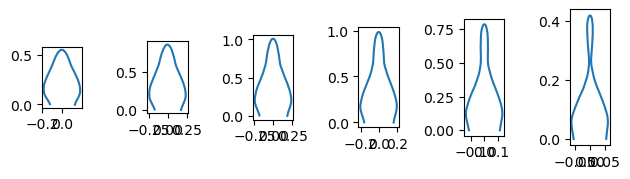

In [87]:
count=1

for i in range(len(scaled_lfs)):
    plt.subplot(1,len(scaled_lfs),count)
    plt.plot(scaled_lfs[i][:,0], scaled_lfs[i][:,1])
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    count+=1